

## Download the data

In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz --no-check-certificate
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz --no-check-certificate

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-04-14 18:05:53--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-04-14 18:05:54--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-04-14 18:05:54--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.

--2023-04-14 18:06:56--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz [following]
--2023-04-14 18:06:56--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz [following]
--2023-04-14 18:06:56--  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
Reusing existing connect

In [2]:
"""
## Prepare paths of input images and target segmentation masks
"""

import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [3]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")  and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 7390


In [4]:
#The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc.
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


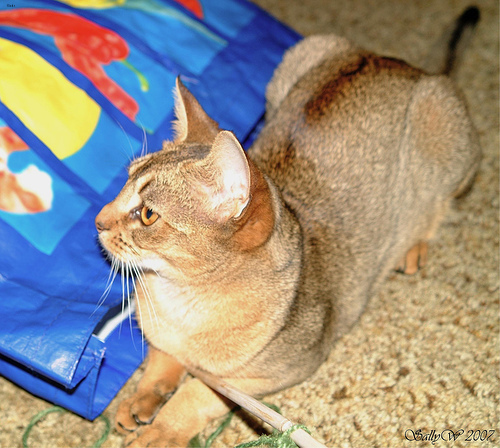

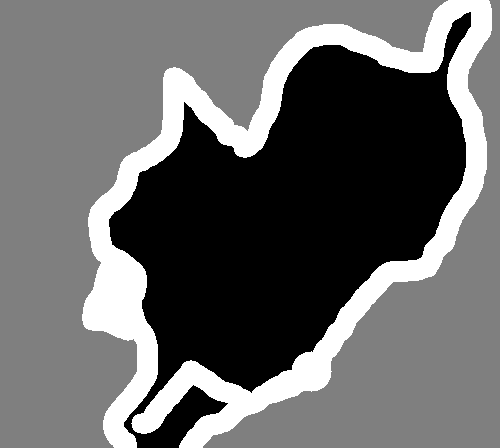

In [5]:
"""
## What does one input image and corresponding segmentation mask look like?
"""

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [6]:
"""
## Prepare `Sequence` class to load & vectorize batches of data
"""

from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


In [7]:
"""
## Prepare U-Net Xception-style model
"""

from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [8]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

In [9]:
"""
## Set aside a validation split
"""

import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [10]:
"""
## Train the model
"""

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 48s 169ms/step - loss: 1.0853 - val_loss: 2.2610
Epoch 2/15
199/199 [==============================] - 33s 167ms/step - loss: 0.5100 - val_loss: 2.1157
Epoch 3/15
199/199 [==============================] - 33s 167ms/step - loss: 0.4286 - val_loss: 0.4494
Epoch 4/15
199/199 [==============================] - 34s 168ms/step - loss: 0.3837 - val_loss: 0.3727
Epoch 5/15
199/199 [==============================] - 33s 167ms/step - loss: 0.3471 - val_loss: 0.4963
Epoch 6/15
199/199 [==============================] - 33s 168ms/step - loss: 0.3201 - val_loss: 0.4126
Epoch 7/15
199/199 [==============================] - 34s 168ms/step - loss: 0.2955 - val_loss: 0.3744
Epoch 8/15
199/199 [==============================] - 34s 169ms/step - loss: 0.2725 - val_loss: 0.3940
Epoch 9/15
199/199 [==============================] - 34s 171ms/step - loss: 0.2549 - val_loss: 0.3627
Epoch 10/15
199/199 [==============================] - 34s 168ms/step - l

In [11]:
import time

In [12]:

"""
## Visualize predictions
"""

# Generate predictions for all images in the validation set



val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
%time
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


Wall time: 0 ns
31/31 [==============================] - 3s 87ms/step


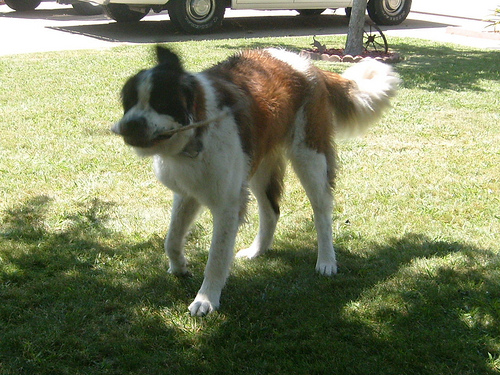

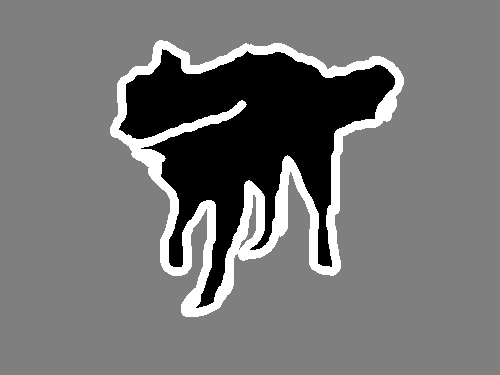

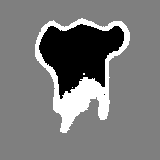

In [16]:
# Display results for validation image #10
i = 12

# Display input image
display(Image(filename=val_input_img_paths[i]))
# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [14]:
import cv2
import matplotlib.pyplot as plt


Wall time: 0 ns
1/1 [==============================] - 1s 901ms/step


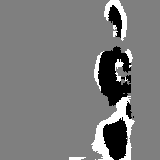

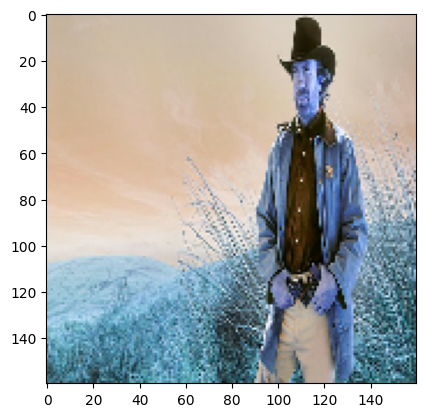

In [15]:
#Loading the file
img2 = cv2.imread("chuck-1200x628.jpg")
#Format for the Mul:0 Tensor
img2= cv2.resize(img2,dsize=(160,160), interpolation = cv2.INTER_CUBIC)
np_image_data = np.asarray(img2)
np_final = np.expand_dims(np_image_data,axis=0)

plt.imshow(img2)
%time
img_pred=model.predict(np_final)

mask = np.argmax(img_pred[0], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
display(img)

<div style="text-align: right">This lab based on fchollet's Image segmentation with a U-Net-like architecture.</div>